In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
from timeit import default_timer as timer
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Activation, Dropout, Reshape, Concatenate
from keras.layers.embeddings import Embedding
from keras.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization

In [4]:
sales_test = pd.read_csv(r'test.csv')

In [5]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:].copy()
    test_pred = test['cnt_shop_item'].copy()
    test.drop('cnt_shop_item', axis = 1, inplace = True)
    return(test, test_pred)

In [6]:
def create_cv_sets2(months, data):
    X_train = data.loc[~data['date_block_num'].isin(months+[34]),:].drop('cnt_shop_item', axis=1)
    X_val = data.loc[data['date_block_num'].isin(months),:]
    X_val, y_val = create_test(X_val)
    X_test = data.loc[data['date_block_num'] == 34,:].drop('cnt_shop_item',axis=1)
    y_train = data.loc[~data['date_block_num'].isin(months+[34]),'cnt_shop_item']
    return(dict({'train': X_train, 'val': X_val, 'test': X_test, 'train_y': y_train, 'val_y': y_val}))

In [7]:
with open(r"full_data_2.pkl", "rb") as input_file:
    full_data = pickle.load(input_file)

In [34]:
dict_cat = create_cv_sets2([9,21,33], full_data)

In [35]:
n_feats = [i for i in dict_cat['train'].columns.tolist() if i not in ['date_block_num', 'shop_id', 'item_id', 
                                                                      'item_category_id', 'month', 'year']]
for feat in n_feats:
    scaler = StandardScaler()
    dict_cat['train'][feat] = scaler.fit_transform(dict_cat['train'][feat].values.reshape(-1,1))
    dict_cat['val'][feat] = scaler.transform(dict_cat['val'][feat].values.reshape(-1,1))
    dict_cat['test'][feat] = scaler.transform(dict_cat['test'][feat].values.reshape(-1,1))

In [25]:
order_of_var = [
    'date_block_num',
    
    'shop_id_enc_cnt_shop_item', 'shop_id_enc_cnt_shop',
    'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
    
    'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
    'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
    
    'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
    'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
    
    'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 
    'month_enc_cnt_item', 'month_enc_cnt_itcat', 
    
    'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
    'year_enc_cnt_item', 'year_enc_cnt_itcat',
    
    'sales_shop_item_lag_1', 'price_shop_item_lag_1', 
    'sales_shop_item_lag_2', 'price_shop_item_lag_2',
    'cnt_shop_item_lag_1', 'cnt_shop_item_lag_2',
    'cnt_shop_item_lag_3', 'cnt_shop_item_lag_4',
    'cnt_shop_item_lag_5', 'cnt_shop_item_lag_6',
    'cnt_shop_item_lag_12',
    
    'sales_shop_lag_1', 'price_shop_lag_1',
    'sales_shop_lag_2', 'price_shop_lag_2',
    'cnt_shop_lag_1', 'cnt_shop_lag_2',
    'cnt_shop_lag_3', 'cnt_shop_lag_4',
    'cnt_shop_lag_5', 'cnt_shop_lag_6',
    'cnt_shop_lag_12',
    
    'sales_item_lag_1', 'price_item_lag_1', 
    'sales_item_lag_2', 'price_item_lag_2',
    'cnt_item_lag_1', 'cnt_item_lag_2',
    'cnt_item_lag_3', 'cnt_item_lag_4',
    'cnt_item_lag_5', 'cnt_item_lag_6',
    'cnt_item_lag_12',
    
    'sales_itcat_lag_1', 'price_itcat_lag_1', 
    'sales_itcat_lag_2', 'price_itcat_lag_2',
    'cnt_itcat_lag_1', 'cnt_itcat_lag_2',
    'cnt_itcat_lag_3', 'cnt_itcat_lag_4',
    'cnt_itcat_lag_5', 'cnt_itcat_lag_6',
    'cnt_itcat_lag_12',
    
    'item_name_1', 'item_name_2', 
    'item_name_3', 'item_name_4', 
    'item_name_5', 
    
    'item_category_name_1', 'item_category_name_2', 
    'item_category_name_3', 'item_category_name_4',
    'item_category_name_5']

In [26]:
len(order_of_var)

75

In [38]:
def create_emb_df(mat):
    df = mat.copy()
    df['month']-=1
    df['year']-=2013
    X = []
    cat_ind = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
    for feat in cat_ind:
        X.append(df[feat].values)
    df = df.drop(cat_ind, axis = 1)
    freq_cat = [1,4,4,4,4,4,11,11,11,11,5,5]
    curr = 0
    for i in freq_cat:
        X.append(df.iloc[:,curr:(curr+i)].values)
        curr+=i
    return(X)

In [76]:
nn_dict = dict()
for key in dict_cat.keys():
    nn_dict[key] = create_emb_df(dict_cat[key]) if 'y' not in key else dict_cat[key].values

In [77]:
nn_dict['train']

[array([ 0,  0,  0, ..., 59, 59, 59]),
 array([   32,    33,    35, ..., 22091, 22100, 22139]),
 array([40, 37, 40, ..., 83, 42, 38]),
 array([0, 0, 0, ..., 8, 8, 8]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([[ 0],
        [ 0],
        [ 0],
        ...,
        [32],
        [32],
        [32]]),
 array([[-6.2345533e+00, -1.3888444e+00, -2.9114616e+00, -4.9000564e+00],
        [ 2.9323049e+00, -3.4674257e-01,  4.3985415e+00,  1.9888057e+00],
        [ 2.9323049e+00,  6.2474667e-04,  2.9560995e+00,  5.2822995e-01],
        ...,
        [-5.8465254e-01, -8.1212723e-01,  9.6533239e-01, -7.9759121e-01],
        [-5.8450937e-01, -8.1213677e-01,  9.6526039e-01, -7.9775351e-01],
        [-5.8461505e-01, -8.1214637e-01,  9.6528953e-01, -7.9790860e-01]],
       dtype=float32),
 array([[-1.1109886 , -3.43888   , -0.33035722, -1.1009835 ],
        [-1.1109886 , -3.43888   , -0.33035722, -1.1009835 ],
        [-1.1109886 , -3.43888   , -0.33035722, -1.1009835 ],
        ...,
        [ 0.16370453

Creating a dense embedding neural network

In [49]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    item_id_in = Input((1,), name='item_id_in')
    item_id = Embedding(22170,20)(item_id_in)
    item_id = Reshape((20,))(item_id)
    layers.append(item_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dense(1000, activation='relu',name='fc1')(model)
    model = Dropout(0.3)(model)
    
    model = Dense(500, activation='relu', name='fc2')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(150,activation='relu', name='fc3')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, item_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [50]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (I

In [78]:
early_stopping=EarlyStopping(monitor='val_loss', patience=15)
check_point = ModelCheckpoint('nn_enc_model_dense_pfs4.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=600, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [early_stopping, check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/600
1483908/1483908 [==============================] - 126s 85us/step - loss: 2.6696 - val_loss: 2.6815

Epoch 00001: val_loss improved from inf to 2.68152, saving model to nn_enc_model_dense_pfs4.hdf5
Epoch 2/600
1483908/1483908 [==============================] - 124s 83us/step - loss: 2.2474 - val_loss: 2.7125

Epoch 00002: val_loss did not improve from 2.68152
Epoch 3/600
1483908/1483908 [==============================] - 122s 82us/step - loss: 2.1206 - val_loss: 2.5328

Epoch 00003: val_loss improved from 2.68152 to 2.53284, saving model to nn_enc_model_dense_pfs4.hdf5
Epoch 4/600
1483908/1483908 [==============================] - 123s 83us/step - loss: 2.0361 - val_loss: 2.5065

Epoch 00004: val_loss improved from 2.53284 to 2.50652, saving model to nn_enc_model_dense_pfs4.hdf5
Epoch 5/600
1483908/1483908 [==============================] - 125s 84us/step - loss: 1.9646 - val_loss: 2.4503

Epoch 00005: val_loss improved fr

Without Dropout

In [83]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    item_id_in = Input((1,), name='item_id_in')
    item_id = Embedding(22170,20)(item_id_in)
    item_id = Reshape((20,))(item_id)
    layers.append(item_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dense(1000, activation='relu',name='fc1')(model)
    #model = Dropout(0.3)(model)
    
    model = Dense(500, activation='relu', name='fc2')(model)
    #model = Dropout(0.2)(model)
    
    model = Dense(150,activation='relu', name='fc3')(model)
    #model = Dropout(0.1)(model)
    
    model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, item_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [84]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (I

In [86]:
#early_stopping=EarlyStopping(monitor='val_loss')
check_point = ModelCheckpoint('nn_enc_model_dense_wo_dropout_pfs4.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 88s 60us/step - loss: 1.4376 - val_loss: 2.5177

Epoch 00001: val_loss improved from inf to 2.51767, saving model to nn_enc_model_dense_wo_dropout_pfs4.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 1.3910 - val_loss: 2.4329

Epoch 00002: val_loss improved from 2.51767 to 2.43287, saving model to nn_enc_model_dense_wo_dropout_pfs4.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 89s 60us/step - loss: 1.3479 - val_loss: 2.4762

Epoch 00003: val_loss did not improve from 2.43287
Epoch 4/100
1483908/1483908 [==============================] - 88s 60us/step - loss: 1.3097 - val_loss: 2.6182

Epoch 00004: val_loss did not improve from 2.43287
Epoch 5/100
1483908/1483908 [==============================] - 88s 60us/step - loss: 1.2693 - val_loss: 2.6004

Epoch 00005: val_loss did not improve from 2.43287
Epoch 6/100
148

1483908/1483908 [==============================] - 89s 60us/step - loss: 0.3855 - val_loss: 3.2276

Epoch 00050: val_loss did not improve from 2.43287
Epoch 51/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 0.3796 - val_loss: 3.2870

Epoch 00051: val_loss did not improve from 2.43287
Epoch 52/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 0.3741 - val_loss: 3.3294

Epoch 00052: val_loss did not improve from 2.43287
Epoch 53/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 0.3705 - val_loss: 3.3354

Epoch 00053: val_loss did not improve from 2.43287
Epoch 54/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 0.3653 - val_loss: 3.2828

Epoch 00054: val_loss did not improve from 2.43287
Epoch 55/100
1483908/1483908 [==============================] - 88s 59us/step - loss: 0.3618 - val_loss: 3.2333

Epoch 00055: val_loss did not improve from 2.43287
Epoch 56/100
1483908/1483908 

1483908/1483908 [==============================] - 89s 60us/step - loss: 0.2433 - val_loss: 3.3838

Epoch 00100: val_loss did not improve from 2.43287


In [87]:
#early_stopping=EarlyStopping(monitor='val_loss', patience=15)
check_point = ModelCheckpoint('nn_enc_model_dense_wo_dropout_2_pfs4.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=4096, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 85s 57us/step - loss: 0.2057 - val_loss: 3.3227

Epoch 00001: val_loss improved from inf to 3.32274, saving model to nn_enc_model_dense_wo_dropout_2_pfs4.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1810 - val_loss: 3.3094

Epoch 00002: val_loss improved from 3.32274 to 3.30943, saving model to nn_enc_model_dense_wo_dropout_2_pfs4.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 83s 56us/step - loss: 0.1764 - val_loss: 3.3747

Epoch 00003: val_loss did not improve from 3.30943
Epoch 4/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1768 - val_loss: 3.4191

Epoch 00004: val_loss did not improve from 3.30943
Epoch 5/100
1483908/1483908 [==============================] - 84s 57us/step - loss: 0.1808 - val_loss: 3.3632

Epoch 00005: val_loss did not improve from 3.30943
Epoch 6/100

1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1623 - val_loss: 3.5107

Epoch 00050: val_loss did not improve from 3.30943
Epoch 51/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1632 - val_loss: 3.4982

Epoch 00051: val_loss did not improve from 3.30943
Epoch 52/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1605 - val_loss: 3.5251

Epoch 00052: val_loss did not improve from 3.30943
Epoch 53/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1607 - val_loss: 3.5080

Epoch 00053: val_loss did not improve from 3.30943
Epoch 54/100
1483908/1483908 [==============================] - 82s 55us/step - loss: 0.1603 - val_loss: 3.5244

Epoch 00054: val_loss did not improve from 3.30943
Epoch 55/100
1483908/1483908 [==============================] - 82s 56us/step - loss: 0.1598 - val_loss: 3.4592

Epoch 00055: val_loss did not improve from 3.30943
Epoch 56/100
1483908/1483908 

1483908/1483908 [==============================] - 83s 56us/step - loss: 0.1425 - val_loss: 3.5524

Epoch 00100: val_loss did not improve from 3.30943


With dropout, without early stopping

In [88]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    item_id_in = Input((1,), name='item_id_in')
    item_id = Embedding(22170,20)(item_id_in)
    item_id = Reshape((20,))(item_id)
    layers.append(item_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dense(1000, activation='relu',name='fc1')(model)
    model = Dropout(0.3)(model)
    
    model = Dense(500, activation='relu', name='fc2')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(150,activation='relu', name='fc3')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, item_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [89]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (I

In [90]:
#early_stopping=EarlyStopping(monitor='val_loss')
check_point = ModelCheckpoint('nn_enc_model_dense_with_dropout_pfs4.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 124s 84us/step - loss: 2.8015 - val_loss: 2.8944

Epoch 00001: val_loss improved from inf to 2.89442, saving model to nn_enc_model_dense_with_dropout_pfs4.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 2.2984 - val_loss: 2.6581

Epoch 00002: val_loss improved from 2.89442 to 2.65813, saving model to nn_enc_model_dense_with_dropout_pfs4.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 2.1562 - val_loss: 2.5962

Epoch 00003: val_loss improved from 2.65813 to 2.59625, saving model to nn_enc_model_dense_with_dropout_pfs4.hdf5
Epoch 4/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 2.0670 - val_loss: 2.6130

Epoch 00004: val_loss did not improve from 2.59625
Epoch 5/100
1483908/1483908 [==============================] - 122s 82us/step - loss: 2.0092 - val_loss: 2.

1483908/1483908 [==============================] - 122s 82us/step - loss: 1.0801 - val_loss: 2.9560

Epoch 00049: val_loss did not improve from 2.52021
Epoch 50/100
1483908/1483908 [==============================] - 124s 83us/step - loss: 1.0729 - val_loss: 2.9217

Epoch 00050: val_loss did not improve from 2.52021
Epoch 51/100
1483908/1483908 [==============================] - 126s 85us/step - loss: 1.0673 - val_loss: 2.8914

Epoch 00051: val_loss did not improve from 2.52021
Epoch 52/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 1.0546 - val_loss: 2.8705

Epoch 00052: val_loss did not improve from 2.52021
Epoch 53/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 1.0513 - val_loss: 2.9435

Epoch 00053: val_loss did not improve from 2.52021
Epoch 54/100
1483908/1483908 [==============================] - 123s 83us/step - loss: 1.0448 - val_loss: 2.8716

Epoch 00054: val_loss did not improve from 2.52021
Epoch 55/100
1483908/14

1483908/1483908 [==============================] - 122s 82us/step - loss: 0.8744 - val_loss: 2.9022

Epoch 00099: val_loss did not improve from 2.52021
Epoch 100/100
1483908/1483908 [==============================] - 124s 83us/step - loss: 0.8707 - val_loss: 2.9509

Epoch 00100: val_loss did not improve from 2.52021


Text(0.5,1,'Learning Curve')

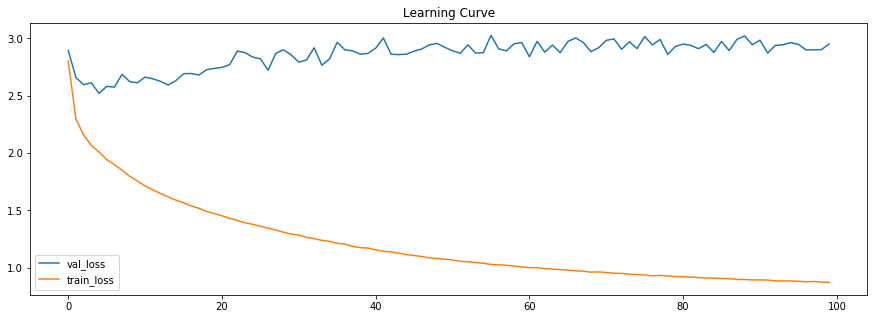

In [113]:
plt.plot(model.history.history['val_loss'], '-', label = 'val_loss' )
plt.plot(model.history.history['loss'], '-', label = 'train_loss')
plt.legend()
plt.title('Learning Curve')

Remove Item Id embedding

In [94]:
for key in nn_dict.keys():
    if 'y' not in key: del nn_dict[key][1]

In [116]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,10)(shop_id_in)
    shop_id = Reshape((10,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dense(1000, activation='relu',name='fc1')(model)
    model = Dropout(0.3)(model)
    
    model = Dense(500, activation='relu', name='fc2')(model)
    model = Dropout(0.2)(model)
    
    model = Dense(150,activation='relu', name='fc3')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [117]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [118]:
#early_stopping=EarlyStopping(monitor='val_loss', patience = 15)
check_point = ModelCheckpoint('nn_enc_model_dense_with_dropout_wo_item_pfs4.hdf5', monitor='val_loss', verbose=1, 
                              save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=50, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/50
1483908/1483908 [==============================] - 121s 81us/step - loss: 2.6986 - val_loss: 2.7007

Epoch 00001: val_loss improved from inf to 2.70067, saving model to nn_enc_model_dense_with_dropout_wo_item_pfs4.hdf5
Epoch 2/50
1483908/1483908 [==============================] - 119s 80us/step - loss: 2.3965 - val_loss: 2.4823

Epoch 00002: val_loss improved from 2.70067 to 2.48235, saving model to nn_enc_model_dense_with_dropout_wo_item_pfs4.hdf5
Epoch 3/50
1483908/1483908 [==============================] - 117s 79us/step - loss: 2.2958 - val_loss: 2.5107

Epoch 00003: val_loss did not improve from 2.48235
Epoch 4/50
1483908/1483908 [==============================] - 119s 80us/step - loss: 2.2272 - val_loss: 2.4846

Epoch 00004: val_loss did not improve from 2.48235
Epoch 5/50
1483908/1483908 [==============================] - 116s 78us/step - loss: 2.1803 - val_loss: 2.4080

Epoch 00005: val_loss improved from 2.48235 to

1483908/1483908 [==============================] - 116s 78us/step - loss: 1.5357 - val_loss: 2.4998

Epoch 00048: val_loss did not improve from 2.35411
Epoch 49/50
1483908/1483908 [==============================] - 116s 78us/step - loss: 1.5284 - val_loss: 2.5288

Epoch 00049: val_loss did not improve from 2.35411
Epoch 50/50
1483908/1483908 [==============================] - 117s 79us/step - loss: 1.5204 - val_loss: 2.5435

Epoch 00050: val_loss did not improve from 2.35411


Text(0.5,1,'Learning Curve')

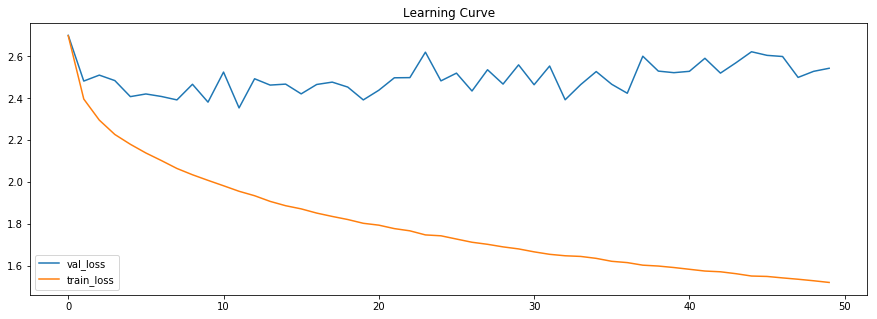

In [120]:
plt.plot(model.history.history['val_loss'], '-', label = 'val_loss' )
plt.plot(model.history.history['loss'], '-', label = 'train_loss')
plt.legend()
plt.title('Learning Curve')

Trying a simpler model with no dropout

In [124]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,10)(shop_id_in)
    shop_id = Reshape((10,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02)(model)
    model = Dense(1000, activation='relu',name='fc1')(model)
    model = Dense(500, activation='relu', name='fc2')(model)
    #model = Dropout(0.2)(model)
    
    #model = Dense(150,activation='relu', name='fc3')(model)
    #model = Dropout(0.1)(model)
    
    #model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [125]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [126]:
#early_stopping=EarlyStopping(monitor='val_loss', patience = 15)
check_point = ModelCheckpoint('nn_enc_model_dense_simple_wo_item_pfs4.hdf5', monitor='val_loss', verbose=1, 
                              save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=50, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/50
1483908/1483908 [==============================] - 78s 53us/step - loss: 2.8510 - val_loss: 2.9745

Epoch 00001: val_loss improved from inf to 2.97454, saving model to nn_enc_model_dense_simple_wo_item_pfs4.hdf5
Epoch 2/50
1483908/1483908 [==============================] - 76s 51us/step - loss: 2.3736 - val_loss: 2.7426

Epoch 00002: val_loss improved from 2.97454 to 2.74261, saving model to nn_enc_model_dense_simple_wo_item_pfs4.hdf5
Epoch 3/50
1483908/1483908 [==============================] - 76s 51us/step - loss: 2.2696 - val_loss: 2.6175

Epoch 00003: val_loss improved from 2.74261 to 2.61748, saving model to nn_enc_model_dense_simple_wo_item_pfs4.hdf5
Epoch 4/50
1483908/1483908 [==============================] - 75s 51us/step - loss: 2.2002 - val_loss: 2.6246

Epoch 00004: val_loss did not improve from 2.61748
Epoch 5/50
1483908/1483908 [==============================] - 76s 51us/step - loss: 2.1431 - val_loss: 2.4924

1483908/1483908 [==============================] - 75s 51us/step - loss: 1.2249 - val_loss: 2.6880

Epoch 00048: val_loss did not improve from 2.36323
Epoch 49/50
1483908/1483908 [==============================] - 75s 51us/step - loss: 1.2164 - val_loss: 2.6527

Epoch 00049: val_loss did not improve from 2.36323
Epoch 50/50
1483908/1483908 [==============================] - 76s 51us/step - loss: 1.2055 - val_loss: 2.6111

Epoch 00050: val_loss did not improve from 2.36323


Text(0.5,1,'Learning Curve')

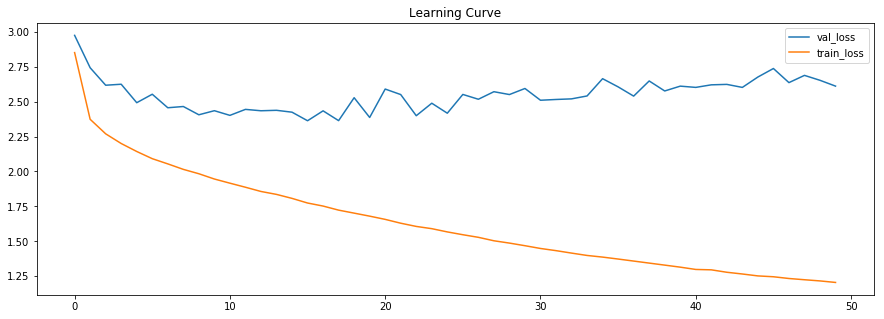

In [127]:
plt.plot(model.history.history['val_loss'], '-', label = 'val_loss' )
plt.plot(model.history.history['loss'], '-', label = 'train_loss')
plt.legend()
plt.title('Learning Curve')

Applying Batchnorm

In [128]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,10)(shop_id_in)
    shop_id = Reshape((10,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02)(model)
    model = Dense(1000, activation='relu',name='fc1')(model)
    model = BatchNormalization()(model)
    model = Dense(500, activation='relu', name='fc2')(model)
    model = BatchNormalization()(model)
    #model = Dropout(0.2)(model)
    
    #model = Dense(150,activation='relu', name='fc3')(model)
    #model = Dropout(0.1)(model)
    
    #model = Dense(15, activation='relu',name='fc4')(model)
    model= Dense(1,name='fc5')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [129]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [ ]:
#early_stopping=EarlyStopping(monitor='val_loss', patience = 15)
check_point = ModelCheckpoint('nn_enc_model_dense_simple_bn_wo_item_pfs4.hdf5', monitor='val_loss', verbose=1, 
                              save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=50, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/50
1483908/1483908 [==============================] - 128s 86us/step - loss: 2.9079 - val_loss: 2.7281

Epoch 00001: val_loss improved from inf to 2.72814, saving model to nn_enc_model_dense_simple_bn_wo_item_pfs4.hdf5
Epoch 2/50
1483908/1483908 [==============================] - 125s 84us/step - loss: 2.3333 - val_loss: 2.6653

Epoch 00002: val_loss improved from 2.72814 to 2.66527, saving model to nn_enc_model_dense_simple_bn_wo_item_pfs4.hdf5
Epoch 3/50
1483908/1483908 [==============================] - 126s 85us/step - loss: 2.2331 - val_loss: 2.3795

Epoch 00003: val_loss improved from 2.66527 to 2.37945, saving model to nn_enc_model_dense_simple_bn_wo_item_pfs4.hdf5
Epoch 4/50
1483908/1483908 [==============================] - 124s 84us/step - loss: 2.1743 - val_loss: 2.4331

Epoch 00004: val_loss did not improve from 2.37945
Epoch 5/50
1483908/1483908 [==============================] - 126s 85us/step - loss: 2.1177 - va